(sviluppo-strumento-notebook)=
# Costruzione di test psicometrici 

In [1]:
source("_common.R")

La maggior parte degli psicologi che utilizzano i test non creano test ad hoc ma piuttosto utilizzano test già validati e interpretano i punteggi sulla base delle norme fornite nel manuale del test. Quando si sceglie il test più appropriato per il problema da affrontare, è necessario considerare diverse domande. Ad esempio, qual è il valore minimo di attendibilità richiesto? In altre parole, a che livello di precisione è necessario essere in grado di differenziare tra i rispondenti? Che tipo di validità è importante? Quali sono le caratteristiche della popolazione che il gruppo normativo deve rappresentare? Qual è il livello di istruzione richiesto per completare il test? Quanto tempo è disponibile per la somministrazione del test e per lo scoring dei risultati? Quali sono i costi necessari per la somministrazione del test e per lo scoring dei risultati?

Dopo aver risposto a queste domande, la selezione del test si riduce solitamente ad una scelta tra poche alternative. Per prendere una decisione tra queste alternative, è importante consultare la letteratura specialistica che discute le proprietà psicometriche dei test e la loro validità. In questo modo, si può effettuare una scelta informata basata sulla conoscenza delle proprietà del test e sulla sua validità, e assicurarsi che sia adatto alla popolazione e alle esigenze specifiche del caso in questione.

Ogni psicologo ha l'obbligo di dimostrare che il test che sceglie per un determinato scopo sia il miglior strumento tra quelli disponibili per giungere ad una decisione razionale e obiettiva relativamente al problema che si trova ad affrontare (come indicato dal Codice Deontologico). Se nessuno dei test disponibili risulta appropriato per misurare un tratto psicologico specifico, si procede alla costruzione di un nuovo reattivo. La costruzione di un test richiede conoscenze specialistiche sia di tipo psicometrico che del fenomeno considerato.

Le fasi di costruzione dei test includono la definizione delle aree di contenuto che il test dovrà misurare; la generazione di un numero di item per ciascuna area circa tre volte superiore rispetto a quelli che si prevede faranno parte della versione finale del test; la somministrazione degli item ad un campione sufficientemente ampio (con centinaia di rispondenti selezionati in modo tale che il campione sia rappresentativo della popolazione di interesse); l'analisi degli item per selezionare quelli migliori; infine, la somministrazione della versione revisionata del test ad un nuovo campione per verificare se la versione finale del test sia soddisfacente dal punto di vista psicometrico. In caso affermativo, il campione esaminato fornisce le norme del test, e questa fase è chiamata "standardizzazione del test".

Per illustrare le fasi cruciali nella costruzione di un test psicometrico, utilizzeremo un caso pratico basato su dati reali, seguendo le linee guida proposte da {cite:t}`dima2018scale`. In questo esempio, prescindiamo dalla fase di creazione degli item, assumendo che siano già stati sviluppati da esperti, e in numero superiore a quello richiesto per la scala finale.

Ci focalizzeremo sulla procedura di selezione degli item. Per il nostro caso, consideriamo item sviluppati dagli psicologi dell'ospedale Meyer, mirati a identificare le famiglie che affrontano maggiori difficoltà nel coping dopo la diagnosi di una malattia grave, spesso terminale, di un figlio. In questa guida, ci concentreremo su un insieme di 20 item specificamente progettati per valutare le caratteristiche del bambino, così come percepite dai genitori. L'obiettivo è selezionare 4 di questi 20 item in modo che rispettino i criteri di una scala psicometrica ben strutturata.

## Importazione dei dati

In [43]:
library("here")
library("tidyverse")
library("TAM")
library("mirt")
library("lavaan")
library("mokken")
library("psych")


df_tot <- readRDS("data/fai_2022_11_20.rds")

temp <- df_tot |> 
  dplyr::filter(FLAG == "keep")
temp$FLAG <- NULL


Caricamento pacchetto: 'psych'


Il seguente oggetto `e mascherato da 'package:mokken':

    ICC


Il seguente oggetto `e mascherato da 'package:lavaan':

    cor2cov


I seguenti oggetti sono mascherati da 'package:scales':

    alpha, rescale


I seguenti oggetti sono mascherati da 'package:ggplot2':

    %+%, alpha




Per migliorare la qualità del nostro set di dati, rimuoveremo gli item che presentano livelli eccessivi di asimmetria (skewness) e curtosi. Questo passaggio è fondamentale per garantire che i nostri dati siano ben distribuiti e rappresentativi, migliorando così l'affidabilità e la validità delle nostre analisi. Gli item con asimmetria e curtosi estreme possono infatti distorcere i risultati degli analisi statistiche e influenzare negativamente le conclusioni tratte dallo studio.

In [6]:
items_stats <- psych::describe(temp)

items_skew_kurt_bad <- items_stats |>
    dplyr::filter(skew > 2.5 | kurtosis > 7.5) |>
    row.names()
items_skew_kurt_bad

[1] "other*"                 "child_birth_place"      "has_chronic_disease"   
 [4] "hospitalization_number" "emergency_care_number"  "divorce"               
 [7] "low_income"             "change_address"         "change_city"           
[10] "is_mother_italian"      "is_father_italian"      "is_father_working"     
[13] "is_child_italian"       "FAI_24"                 "FAI_32"                
[16] "FAI_52"                 "FAI_53"                 "FAI_61"                
[19] "FAI_74"                 "FAI_76"                 "FAI_77"                
[22] "FAI_138"                "FAI_152"                "FAI_174"               
[25] "FAI_175"                "FAI_182"                "FAI_193"

In [7]:
# Select the strings starting with "FAI_"
bad_fai_items <- grep("^FAI_", items_skew_kurt_bad, value = TRUE)

df <- temp |>
    dplyr::select(!any_of(bad_fai_items))

Ci concentreremo qui su un sottoinsieme di item, ovvero quelli che riguardano le caratteristiche del bambino.

In [8]:
# First subscale: items names.
item_subscale <- c(
    "FAI_49", "FAI_106", "FAI_60", "FAI_124", "FAI_86",
    "FAI_47", "FAI_121", "FAI_167", "FAI_99",
    "FAI_63", "FAI_168", "FAI_5", "FAI_132", "FAI_85", "FAI_81",
    "FAI_83",
    # "FAI_152",  "FAI_175",
    "FAI_57", "FAI_91", "FAI_135", "FAI_1"
)

# Select only the items of this subscale.
subscale_data <- df %>%
    dplyr::select(all_of(item_subscale))
dim(subscale_data)

[1] 453  20

## Statistiche descrittive

In [9]:
psych::describe(subscale_data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FAI_49,1,453,0.5629139,1.0320709,0,0.3085399,0.0000,0,4,4,2.0665609,3.6052375,0.04849092
FAI_106,2,453,0.6710817,0.9911011,0,0.4710744,0.0000,0,4,4,1.6036473,2.0835785,0.04656599
FAI_60,3,453,0.9403974,1.2169441,0,0.7272727,0.0000,0,4,4,1.1792903,0.2955897,0.05717702
FAI_124,4,453,1.0463576,1.1955175,1,0.8429752,1.4826,0,4,4,1.1667416,0.4658086,0.05617031
FAI_86,5,453,1.1898455,1.0171900,1,1.0606061,1.4826,0,4,4,0.9491960,0.6428214,0.04779175
FAI_47,6,453,1.6247241,1.1132778,2,1.5950413,1.4826,0,4,4,0.1994007,-0.7340689,0.05230635
FAI_121,7,453,0.4900662,0.7121035,0,0.3746556,0.0000,0,4,4,1.8321794,4.5725145,0.03345754
FAI_167,8,453,1.9072848,1.0306218,2,1.8815427,1.4826,0,4,4,0.1974188,-0.2695266,0.04842284
FAI_99,9,453,2.0618102,1.1543198,2,2.0220386,1.4826,0,4,4,0.3447637,-0.7883135,0.05423468


## Mokken scaling

Sia la CTT che la FA operano sotto l'ipotesi che le variabili latenti siano continue. Questo implica che le variabili non osservabili, come tratti di personalità o abilità, sono considerate distribuite lungo un continuum senza interruzioni discrete.

A differenza della CTT e della FA, l'IRT gestisce meglio le variabili discrete e fornisce una stima più accurata di parametri come la difficoltà degli item e la capacità del rispondente. Tuttavia, l'IRT richiede campioni relativamente grandi di rispondenti e item per produrre stime affidabili. Questo è particolarmente vero per gli item ordinali, dove l'ordine delle risposte è significativo ma non la distanza esatta tra le categorie.

Quando si lavora con set di item che misurano variabili latenti ordinali e in presenza di campioni di dimensioni ridotte, l'adattamento dell'IRT parametrico può non essere realistico. In queste situazioni, l'IRT non parametrica (NIRT) è stata sviluppata come un approccio alternativo.

**IRT Non Parametrica (NIRT) e Analisi di Scaling di Mokken (MSA):** La NIRT è raccomandata come analisi preliminare ai modelli IRT. All'interno dei modelli NIRT, l'MSA è particolarmente rilevante. Questo modello è considerato l'equivalente ordinale delle analisi di Rasch e della Rating Scale. Esso opera sotto tre proprietà principali:

- **Unidimensionalità:** Assume che esista una sola variabile latente (θ) che spieghi la variazione nelle risposte agli item.
- **Indipendenza Locale:** Suggerisce che le risposte agli item sono indipendenti l'una dall'altra, date le condizioni della variabile latente (θ).
- **Monotonicità Latente:** Implica che la probabilità di risposta positiva ad un item non diminuisce a livelli più alti della variabile latente.

**Proprietà Supplementari nella MSA:**

- **Ordinamento Invariante degli Item:** Gli item devono mantenere lo stesso ordine di difficoltà a tutti i livelli della variabile latente.
- **Identificazione di Modelli di Risposta Idiosincratici:** Questo riguarda la rilevazione di risposte che non si allineano con il modello complessivo, come quando un rispondente non approva un item "più facile" pur avendo approvato uno "più difficile".

Le assunzioni di unidimensionalità, indipendenza locale e monotonicità latente definiscono il modello IRT non parametrico più generale: il modello di omogeneità monotona, anche noto come modello non parametrico di risposta graduata.

In sintesi, mentre la CTT e la FA sono più adatte per variabili latenti continue, l'IRT e, in particolare, la MSA forniscono metodi robusti per analizzare dati psicometrici in presenza di variabili latenti ordinali e campioni di dimensioni ridotte.

### Scalability coefficients

1. **Coefficiente di Scalabilità tra Coppie di Item (Hij):** Per ogni coppia di item (i, j), esiste un coefficiente di scalabilità Hij. Questo coefficiente misura quanto bene due item lavorano insieme per riflettere la variabile latente. In formula, possiamo esprimerlo come:

   $$ Hij ; i, j = 1, \ldots, J $$

   In MSA, è importante che gli item appartenenti alla stessa scala di Mokken abbiano coefficienti di scalabilità positivi, indicando che sono coerenti e misurano la stessa variabile latente.

2. **Coefficiente di Scalabilità dell'Item (Hj):** Hj può essere interpretato in modo simile ai parametri di discriminazione nell'IRT parametrico. Indica quanto bene un singolo item discrimina tra individui con diversi livelli della variabile latente. Si aspetta che sia maggiore di un certo limite inferiore positivo, di solito c > 0.3.

3. **Coefficiente di Scalabilità del Test (H):** H rappresenta la misura di scalabilità per l'intero set di item. Le soglie euristiche per interpretare H sono:
    - **Debole:** se 0.3 ≤ H < 0.4.
    - **Moderato:** se 0.4 ≤ H < 0.5.
    - **Forte:** se H > 0.5.

   Questi valori danno un'idea della forza con cui il set di item misura la variabile latente.

Secondo Sijtsma e Molenaar (2002), le assunzioni di unidimensionalità, indipendenza locale e monotonicità latente implicano alcune restrizioni sui coefficienti di scalabilità:
    - 0 ≤ Hij ≤ 1, per tutte le coppie di item i ≠ j.
    - 0 ≤ Hj ≤ 1, per tutti gli item j.
    - 0 ≤ H ≤ 1, per l'intero set di item.

In termini più intuitivi, questi coefficienti di scalabilità aiutano a valutare quanto efficacemente un insieme di item lavori insieme per misurare una variabile latente. Valori alti di H indicano che il set di item è fortemente correlato e misura in modo affidabile la variabile latente. Questi indici sono cruciali per garantire che l'analisi effettuata con la MSA sia valida e affidabile.

In [20]:
# Calculate H coefficients
subscale_data <- as.data.frame(subscale_data)
coefs.h <- coefH(subscale_data)
coefs.h$Hi
coefs.h$H

$Hij
        FAI_49  se      FAI_106 se      FAI_60  se      FAI_124 se     
FAI_49                   0.561  (0.057)  0.608  (0.054)  0.601  (0.048)
FAI_106  0.561  (0.057)                  0.617  (0.042)  0.722  (0.039)
FAI_60   0.608  (0.054)  0.617  (0.042)                  0.688  (0.037)
FAI_124  0.601  (0.048)  0.722  (0.039)  0.688  (0.037)                
FAI_86   0.039  (0.046)  0.141  (0.058)  0.137  (0.055)  0.104  (0.052)
FAI_47   0.258  (0.062)  0.161  (0.063)  0.246  (0.053)  0.192  (0.052)
FAI_121  0.139  (0.048)  0.299  (0.050)  0.227  (0.053)  0.383  (0.059)
FAI_167  0.071  (0.065)  0.108  (0.061)  0.210  (0.056)  0.147  (0.054)
FAI_99   0.139  (0.060)  0.120  (0.053)  0.208  (0.053)  0.222  (0.050)
FAI_63   0.171  (0.059)  0.152  (0.052)  0.208  (0.052)  0.203  (0.051)
FAI_168  0.210  (0.060)  0.277  (0.056)  0.280  (0.055)  0.287  (0.055)
FAI_5    0.212  (0.056)  0.317  (0.055)  0.280  (0.052)  0.288  (0.052)
FAI_132  0.305  (0.063)  0.272  (0.059)  0.135  (0.056)  0.

        Item H  se     
FAI_49    0.248 (0.027)
FAI_106   0.296 (0.024)
FAI_60    0.301 (0.023)
FAI_124   0.320 (0.023)
FAI_86    0.161 (0.024)
FAI_47    0.227 (0.025)
FAI_121   0.185 (0.027)
FAI_167   0.185 (0.027)
FAI_99    0.125 (0.026)
FAI_63    0.225 (0.024)
FAI_168   0.228 (0.026)
FAI_5     0.229 (0.026)
FAI_132   0.211 (0.026)
FAI_85    0.175 (0.029)
FAI_81    0.244 (0.024)
FAI_83    0.238 (0.023)
FAI_57    0.208 (0.024)
FAI_91    0.184 (0.025)
FAI_135   0.147 (0.027)
FAI_1     0.105 (0.031)

Scale H      se 
  0.218 (0.014) 

Si noti che, per alcune coppie di item, il Coefficiente di Scalabilità tra Coppie di Item (Hij) è negativo. Inoltre, solo per due item il Coefficiente di Scalabilità dell'Item (Hj) è maggiore di 0.3. Infine, il Coefficiente di Scalabilità del Test (H), quando sono presenti tutti gli item, è debole. È dunque necessario procedere ad una selezione degli item. A questo fine, useremo una *Automated Item Selection Procedure* eseguita dalla funzione `aisp()`, la quale seleziona gli item che formano una scala coerente sulla base dello scalability coefficient (H). Utilizziamo una soglia minima di 0.4.

In [21]:
# Save a list with H coefficients for each item and for the whole scale
coefs.h.all <- list(coefs.h[[2]], coefs.h[[3]])

# remove items below aisp treshold of .4
aisp.lb <- aisp(subscale_data, lowerbound = .4)
good_items <- subscale_data[, aisp.lb == 1]
names(good_items)
coefH(good_items)

[1] "FAI_49"  "FAI_106" "FAI_60"  "FAI_124"

$Hij
        FAI_49  se      FAI_106 se      FAI_60  se      FAI_124 se     
FAI_49                   0.561  (0.057)  0.608  (0.054)  0.601  (0.048)
FAI_106  0.561  (0.057)                  0.617  (0.042)  0.722  (0.039)
FAI_60   0.608  (0.054)  0.617  (0.042)                  0.688  (0.037)
FAI_124  0.601  (0.048)  0.722  (0.039)  0.688  (0.037)                

$Hi
        Item H  se     
FAI_49    0.591 (0.045)
FAI_106   0.636 (0.036)
FAI_60    0.641 (0.033)
FAI_124   0.671 (0.030)

$H
Scale H      se 
  0.636 (0.032) 



Con questo metodo di selezione degli item, otteniamo che il Coefficiente di Scalabilità tra Coppie di Item (Hij) è sempre positivo, il Coefficiente di Scalabilità dell'Item (Hj) è circa uguale a 0.6 o maggiore, e il Coefficiente di Scalabilità del Test (H) è di intensità forte, ovvero 0.64.

Esaminiamo la monotonicità. 

,ItemH,#ac,#vi,#vi/#ac,maxvi,sum,sum/#ac,zmax,#zsig,crit
FAI_49,0.59,12,0,0,0,0,0,0,0,0
FAI_106,0.64,6,0,0,0,0,0,0,0,0
FAI_60,0.64,10,0,0,0,0,0,0,0,0
FAI_124,0.67,12,0,0,0,0,0,0,0,0


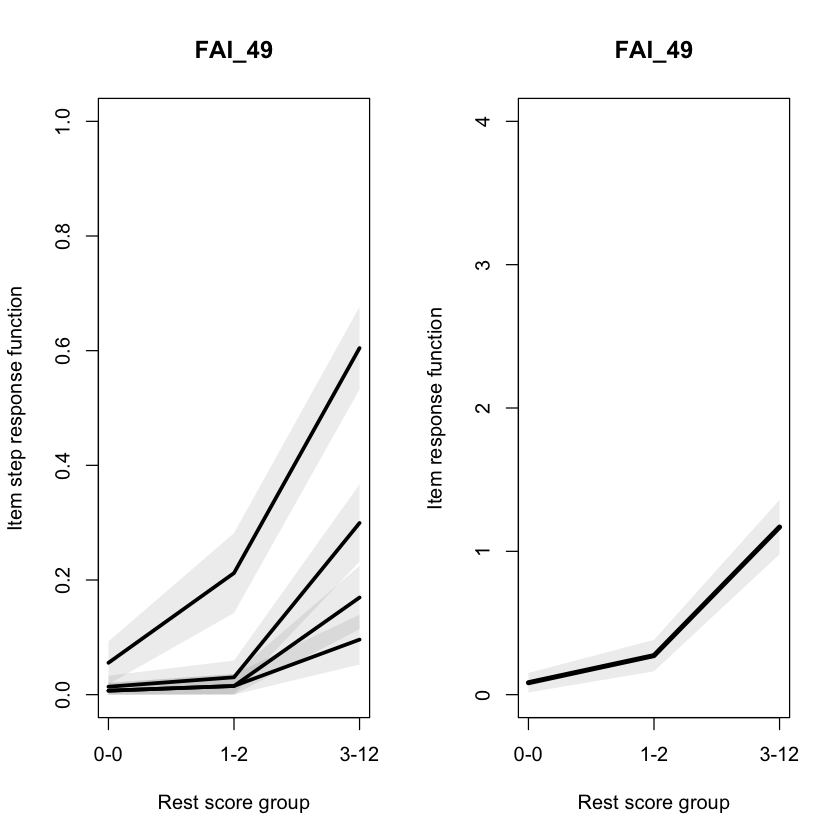

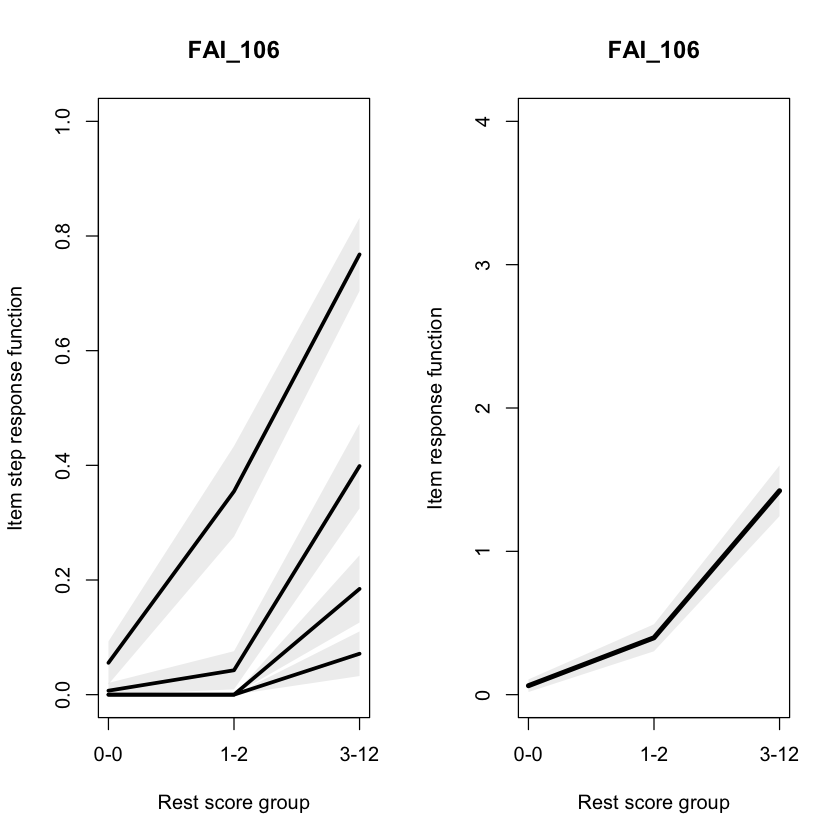

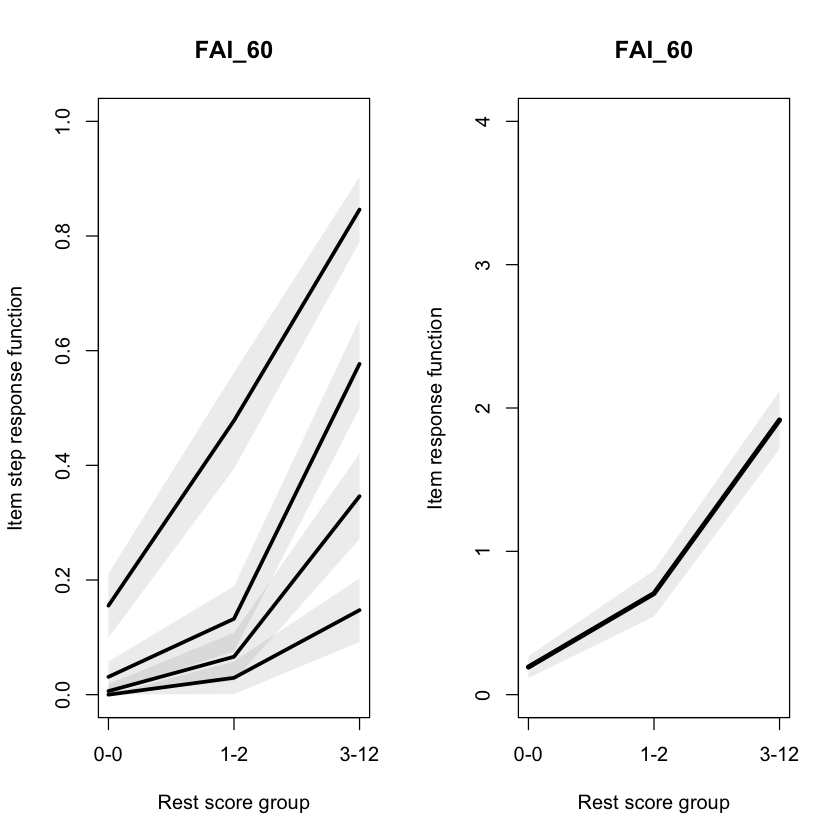

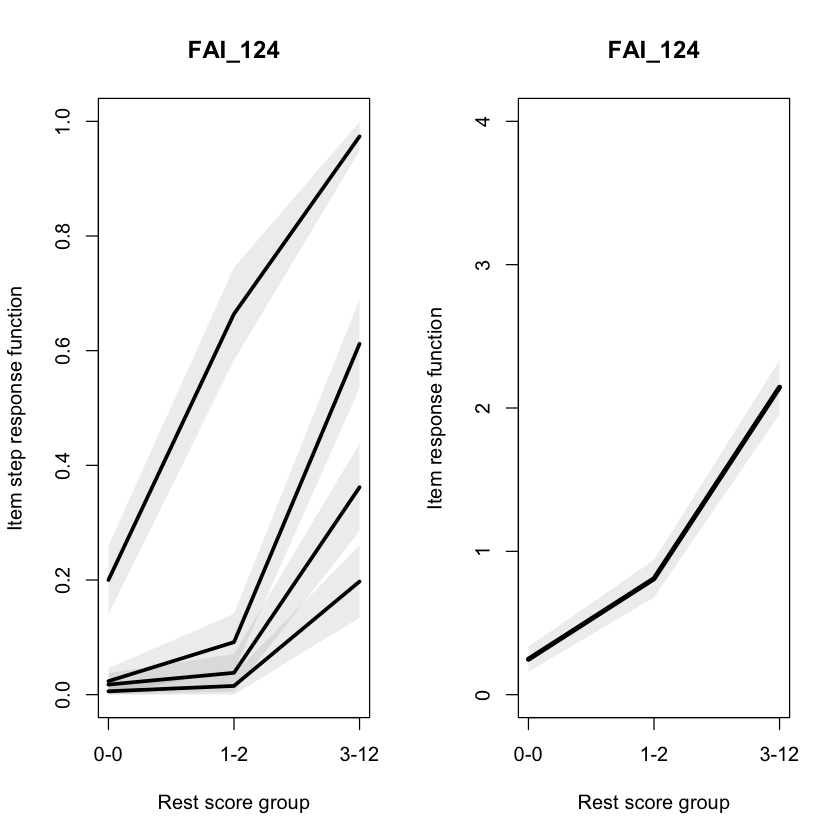

In [22]:
# Examine the monotonicity
mc <- check.monotonicity(good_items)
summary(mc)
plot(mc)

La monotonicità è un'assunzione chiave nella scala Mokken e indica che la probabilità di una risposta positiva (o di punteggio più alto) a un item dovrebbe aumentare all'aumentare del tratto misurato. I grafici forniscono una rappresentazione grafica della monotonicità degli item; le curve corrispondenti a ciascun item salgono costantemente, indicando una buona monotonicità.

La funzione `check.iio()` è usata per controllare l'invarianza dell'ordine degli item (Item Order Invariance, IIO) in una scala Mokken. La IIO è una proprietà che suggerisce che l'ordine degli item secondo la difficoltà o la gravità è lo stesso per tutti i soggetti, indipendentemente dal livello del tratto misurato (ad esempio, abilità o atteggiamento). Un valore H alto per un item indica un buon adattamento dell'item alla scala e una forte invarianza dell'ordine.

In [23]:
summary(check.iio(good_items))

$method
[1] "MIIO"

$item.summary
        ItemH #ac #vi #vi/#ac maxvi sum sum/#ac tmax #tsig crit
FAI_124  0.67   5   0       0     0   0       0    0     0    0
FAI_60   0.64   5   0       0     0   0       0    0     0    0
FAI_106  0.64   6   0       0     0   0       0    0     0    0
FAI_49   0.59   6   0       0     0   0       0    0     0    0

$backward.selection
        step 1
FAI_124      0
FAI_60       0
FAI_106      0
FAI_49       0

$HT
[1] 0.2189009

Il coefficiente di scalabilità H per ogni item si dimostra adeguato. #vi indica il numero di violazioni dell'invarianza dell'ordine degli item. Un valore di 0 indica nessuna violazione. Dai dati, sembra che non ci siano state violazioni dell'invarianza dell'ordine degli item per nessuno degli item testati (#vi è 0 per tutti).

 L'indice $HT rappresenta l'indice di omogeneità di Hoeffding per la scala. L'indice di Hoeffding, denotato come H, è una misura che valuta quanto bene gli item di un test o di una scala si adattano al modello di scala Mokken. Il valore di 0.219 è l'indice di omogeneità di Hoeffding per la scala. Questo valore è considerato piuttosto basso, suggerendo che gli item nella scala potrebbero non essere fortemente scalabili. In genere, si cerca un valore di H superiore a 0.3 per una scala moderatamente forte.
 
In conclusione, mentre l'analisi IIO non ha rilevato problemi di invarianza dell'ordine, l'indice di omogeneità basso solleva questioni sulla forza complessiva della scala. 

Verifichiamo ora l'indipendenza locale. L'indipendenza locale è un'importante proprietà nelle scale Mokken e implica che la relazione tra qualsiasi coppia di item nella scala è indipendente dal livello degli altri item. In altre parole, gli item dovrebbero essere indipendenti l'uno dall'altro, condizionatamente al tratto misurato dalla scala. 

In [24]:
# Check local independence (conditional association)
ca <- check.ca(good_items, TRUE)
ca$InScale
ca$Index
ca$Flagged

[[1]]
[1] TRUE TRUE TRUE TRUE

[[1]]
[[1]]$W1
           FAI_49   FAI_106    FAI_60   FAI_124
FAI_49         NA 0.5757547 0.2865024 0.2792931
FAI_106 1.3893706        NA 0.6868141 1.5522234
FAI_60  0.9243564 0.5425479        NA 1.3992465
FAI_124 0.5795723 0.8785349 0.7368545        NA

[[1]]$W2
         [,1]     [,2]     [,3]     [,4]
[1,] 3.821573 4.854055 4.194256 3.416568

[[1]]$W3
           FAI_49  FAI_106    FAI_60  FAI_124
FAI_49         NA 1.591594 0.8714913 1.358488
FAI_106 1.5915937       NA 2.2635736 0.998888
FAI_60  0.8714913 2.263574        NA 1.059192
FAI_124 1.3584881 0.998888 1.0591917       NA

[[1]]
[[1]]$F1
        FAI_49 FAI_106 FAI_60 FAI_124
FAI_49       0       0      0       0
FAI_106      0       0      0       0
FAI_60       0       0      0       0
FAI_124      0       0      0       0

[[1]]$F2
     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0

[[1]]$F3
        FAI_49 FAI_106 FAI_60 FAI_124
FAI_49       0       0      0       0
FAI_106      0       0      0       0
FAI_60       0       0      0       0
FAI_124      0       0      0       0

"Flagged" si riferisce agli item che mostrano segni di dipendenza locale o di associazione condizionale. Nell'output, "TRUE TRUE TRUE TRUE" suggerisce che tutti gli item esaminati sono stati segnalati come potenzialmente problematici in termini di indipendenza locale. Questo potrebbe indicare che questi item sono correlati tra loro in qualche modo che non è spiegato solo dal tratto misurato dalla scala. Tuttavia, usando un metodo di calcolo diverso, le matrici $F1, $F2, $F3 indicano quali coppie di item superano una certa soglia di associazione condizionale, suggerendo una possibile violazione dell'indipendenza locale. In questo caso, tutte e tre le matrici $F1, $F2, e $F3 mostrano solo zeri, il che significa che nessuna coppia di item ha superato la soglia di preoccupazione per l'associazione condizionale. Questo è in contrasto con il fatto che gli item sono stati segnalati in $Flagged.

Ora adattiamo ai dati il modello Generalized Partial Credit Model (GPCM) con una variante del modello IRT a due parametri (2PL) e calcoliamo gli indici di adattamento degli item (itemfit) utilizzando la funzione msq.itemfit nel pacchetto TAM di R. 

In [34]:
# Fit 2PL IRT Generalized Partial Credit Model
subscale_2pl <- TAM::tam.mml.2pl(
    good_items,
    irtmodel = "GPCM",
    control = list(
        Msteps = 10, QMC = FALSE, snodes = 0,
        convD = .0001, conv = .00001, convM = .00001
    )
)

....................................................
Processing Data      2023-12-20 11:04:47.861542 
    * Response Data: 453 Persons and  4 Items 
    * Numerical integration with 21 nodes
    * Created Design Matrices   ( 2023-12-20 11:04:47.865855 )
    * Calculated Sufficient Statistics   ( 2023-12-20 11:04:47.86842 )
....................................................
Iteration 1     2023-12-20 11:04:47.870576
E Step
M Step Intercepts   |----------
M Step Slopes       |----
  Deviance = 3840.8656
  Maximum item intercept parameter change: 0.699728
  Maximum item slope parameter change: 0.47538
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0
....................................................
Iteration 2     2023-12-20 11:04:47.889697
E Step
M Step Intercepts   |----------
M Step Slopes       |----
  Deviance = 3705.3077 | Absolute change: 135.5579 | Relative change: 0.03658479
  Maximum item intercept parameter change: 0.463226
  Maximum item slo

In [35]:
subscale_fit <- msq.itemfit(subscale_2pl) # mean square infit, outfit
subscale_fit$itemfit

item,fitgroup,Outfit,Outfit_t,Outfit_p,Infit,Infit_t,Infit_p
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FAI_49,1,1.0375737,0.2854386,0.7753082,1.049352,0.5163703,0.6055958
FAI_106,2,0.9093163,-0.3880002,0.6980159,1.037087,0.4482993,0.6539372
FAI_60,3,1.0115258,0.1322366,0.8947972,1.030302,0.4056650,0.6849888
FAI_124,4,1.0123101,0.2714392,0.7860532,1.051281,0.6414851,0.5212076


I risultati hanno la seguente interpretazione.

- **Item**: Identifica l'item specifico.
- **Fitgroup**: Gruppo di adattamento, probabilmente riferito a diversi sottoinsiemi o tipologie di item nella scala.
- **Outfit**: Media quadratica non ponderata (mean square) dell'outfit. Misura l'adattamento degli item considerando tutte le risposte, con un'enfasi maggiore sulle risposte inaspettate.
- **Outfit_t**: Statistica t dell'outfit. Valori troppo alti o bassi possono indicare problemi di adattamento.
- **Outfit_p**: Valore p associato alla statistica t dell'outfit.
- **Infit**: Media quadratica ponderata (mean square) dell'infit. Simile all'outfit, ma dà più peso alle risposte che si trovano vicino al livello di abilità del soggetto.
- **Infit_t**: Statistica t dell'infit.
- **Infit_p**: Valore p associato alla statistica t dell'infit.

Interpretazione:
1. **Outfit e Infit (Valori Ideali tra 0.7 e 1.3)**: 
   - I valori di Outfit e Infit intorno a 1 sono ideali. Valori troppo lontani da 1 (tipicamente <0.7 o >1.3) possono indicare problemi.
   - Nel tuo caso, i valori di Outfit e Infit sono vicini a 1 per tutti gli item, il che è generalmente buono.

2. **Outfit_t e Infit_t (Valori Assoluti < 2)**:
   - Le statistiche t (Outfit_t, Infit_t) dovrebbero idealmente essere contenute entro +/- 2. Valori al di fuori di questo intervallo possono suggerire adattamenti non ideali.
   - I tuoi risultati mostrano che tutte le statistiche t sono entro questi limiti, il che è positivo.

3. **Outfit_p e Infit_p**:
   - I valori p associati alle statistiche t forniscono un'indicazione di significatività. Valori p molto bassi (<0.05) possono suggerire che l'adattamento di un item è significativamente diverso da quello previsto.
   - Nel tuo caso, nessun valore p è particolarmente basso, suggerendo che non ci sono problemi significativi di adattamento.

In generale, i risultati indicano che non ci sono problemi significativi di adattamento per gli item analizzati. I valori di Outfit e Infit sono vicini a 1, e le statistiche t sono entro i limiti accettabili, suggerendo che gli item si adattano bene al modello GPCM 2PL utilizzato. Questo è un segnale positivo per la validità del tuo strumento di misurazione.

Eseguiamo ora un'analisi di adattamento del modello utilizzando la funzione `tam.modelfit` nel pacchetto `TAM` di R, applicato al modello IRT che è stato precedentemente calcolato (`subscale_2pl`). L'analisi di adattamento del modello è cruciale per valutare se i dati si adattano bene al modello IRT scelto. Ecco come interpretare i risultati:

`subscale_res$Q3_summary`
Questo riepilogo fornisce informazioni su due tipi di residui: Q3 e aQ3.

1. **Q3**: 
   - Questi sono i residui standardizzati, che misurano la discrepanza tra le risposte osservate e quelle previste dal modello.

2. **aQ3**: 
   - Sono i residui aggiustati. Simili ai Q3 ma con alcuni aggiustamenti per migliorare l'interpretazione.

`round(subscale_res$aQ3.matr, 3)`
Questa matrice mostra i residui aggiustati (aQ3) tra coppie di item. Valori vicini a 0 indicano un buon adattamento tra le coppie di item. Valori positivi o negativi distanti da 0 indicano possibili discrepanze tra le risposte osservate e quelle previste dal modello per quelle coppie di item.

In [37]:
subscale_res <- TAM::tam.modelfit(subscale_2pl)
subscale_res$Q3_summary
round(subscale_res$aQ3.matr, 3)

**** Calculate Residuals 
**** Calculate Counts 
**** Calculate Covariances 


type,M,SD,min,max,SGDDM,wSGDDM
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Q3,-2.650361e-01,0.1439307,-0.4326832,-0.0241171,0.2650361,0.2650361
aQ3,1.045685e-17,0.1439307,-0.1676472,0.2409190,0.1282120,0.1282120


,FAI_49,FAI_106,FAI_60,FAI_124
FAI_49,NA,0.115,0.241,-0.091
FAI_106,0.115,NA,0.029,-0.126
FAI_60,0.241,0.029,NA,-0.168
FAI_124,-0.091,-0.126,-0.168,NA


Nei dati esaminati, la media dei residui (sia per Q3 che aQ3) è vicina a zero, il che è un buon segno. 
I valori nella matrice dei residui aggiustati non mostrano grandi discrepanze, suggerendo un adattamento generalmente buono degli item al modello IRT.

In conclusione, i risultati suggeriscono che il modello IRT si adatta in modo ragionevolmente buono ai dati. Non ci sono grandi discrepanze evidenziate dai residui, indicando che il modello è in grado di spiegare in modo efficace le risposte degli item. 

Consideriamo i parametri degli item, inclusi i livelli di difficoltà e la discriminazione, per individuare eventuali item estremi (o troppo facili o troppo difficili).

- xsi: Rappresenta il livello di difficoltà degli item. Valori più alti indicano item più difficili.
- alpha: Indica la discriminazione dell'item, ovvero quanto bene l'item distingue tra soggetti con diversi livelli del tratto misurato. Valori più alti indicano una maggiore discriminazione.
- beta: Rappresenta un parametro di posizione che, nel contesto del GPCM, può essere interpretato in relazione alla difficoltà degli item.
- tau.Cat: Questi sono i parametri di soglia per le diverse categorie di risposta, che indicano il punto in cui un soggetto ha una probabilità uguale di rispondere in una categoria o in quella successiva.

In [38]:
summary(subscale_2pl)

------------------------------------------------------------
TAM 4.1-4 (2022-08-28 16:03:54) 
R version 4.3.2 (2023-10-31) aarch64, darwin20 | nodename=Air-di-Corrado.home-life.hub | login=root 

Date of Analysis: 2023-12-20 11:04:55.050952 
Time difference of 7.189958 secs
Computation time: 7.189958 

Multidimensional Item Response Model in TAM 

IRT Model: GPCM
Call:
TAM::tam.mml.2pl(resp = good_items, irtmodel = "GPCM", control = list(Msteps = 10, 
    QMC = FALSE, snodes = 0, convD = 1e-04, conv = 1e-05, convM = 1e-05))

------------------------------------------------------------
Number of iterations = 521 
Numeric integration with 21 integration points

Deviance = 3606.21 
Log likelihood = -1803.1 
Number of persons = 453 
Number of persons used = 453 
Number of items = 4 
Number of estimated parameters = 20 
    Item threshold parameters = 16 
    Item slope parameters = 4 
    Regression parameters = 0 
    Variance/covariance parameters = 0 

AIC = 3646  | penalty=40    | AIC=


C'è una notevole variazione nella difficoltà tra i diversi item e anche tra le categorie di risposta all'interno degli stessi item.  Idealmente, una scala dovrebbe avere item che coprono un'ampia gamma di difficoltà per essere efficace nel misurare soggetti con diversi livelli di abilità. Item con una vasta gamma di difficoltà (come FAI_106 e FAI_124) possono essere particolarmente utili per discriminare tra soggetti con livelli diversi di abilità/tratti. Item con un intervallo di difficoltà più stretto (come FAI_49 e FAI_60) possono essere più utili per misurare soggetti attorno a specifici livelli di abilità.

Possiamo ora esaminare i valori di discriminazione (noti anche come parametri di pendenza o "slope" in IRT, indicati con "alpha" nel tuo output) per identificare eventuali item che offrono relativamente poche informazioni per classificare in modo affidabile i partecipanti. Nell'Item Response Theory, un valore di pendenza più alto indica che l'item è più efficace nel discriminare tra i soggetti con diversi livelli del tratto misurato.

- FAI_49:
Alpha = 1.238. Questo valore suggerisce una discriminazione moderata. L'item è abbastanza efficace nel distinguere tra soggetti a diversi livelli del tratto.
- FAI_106:
Alpha = 1.983. Questo è un valore di discriminazione abbastanza alto, indicando che l'item è molto efficace nel discriminare tra i soggetti.
- FAI_60:
Alpha = 1.596. Anche questo è un buon valore di discriminazione, indicando che l'item è efficace nel differenziare tra i soggetti.
- FAI_124:
Alpha = 3.536. Questo è un valore di discriminazione molto alto, il che significa che l'item è particolarmente efficace nel discriminare tra soggetti a diversi livelli del tratto.

In base ai valori di alpha forniti, non sembra esserci alcun item che offra relativamente poche informazioni per classificare in modo affidabile i partecipanti. Tutti gli item mostrano una discriminazione da moderata ad alta. Item con alta discriminazione sono particolarmente utili in una scala IRT, in quanto contribuiscono maggiormente a distinguere tra soggetti a diversi livelli del tratto di interesse. In conclusione, gli item nella tua scala sembrano avere buone proprietà discriminative, il che suggerisce che sono efficaci nel misurare il tratto di interesse e nel distinguere tra i partecipanti a diversi livelli di quel tratto.

Per esaminare la funzione di informazione degli item (Item Information Function, IIF) nel contesto della Teoria della Risposta all'Item (IRT), possiamo utilizzare il pacchetto `mirt` in R per modellare i dati e successivamente generare dei grafici che mostrano la quantità di informazione fornita da ciascun item lungo il continuum del tratto latente. 

In [39]:
mod <- mirt(
    data = good_items,
    1,
    itemtype = "graded",
    SE = TRUE,
    verbose = FALSE
)

Questi grafici mostrano la probabilità di risposta a ciascuna categoria di un item in funzione del livello del tratto latente.

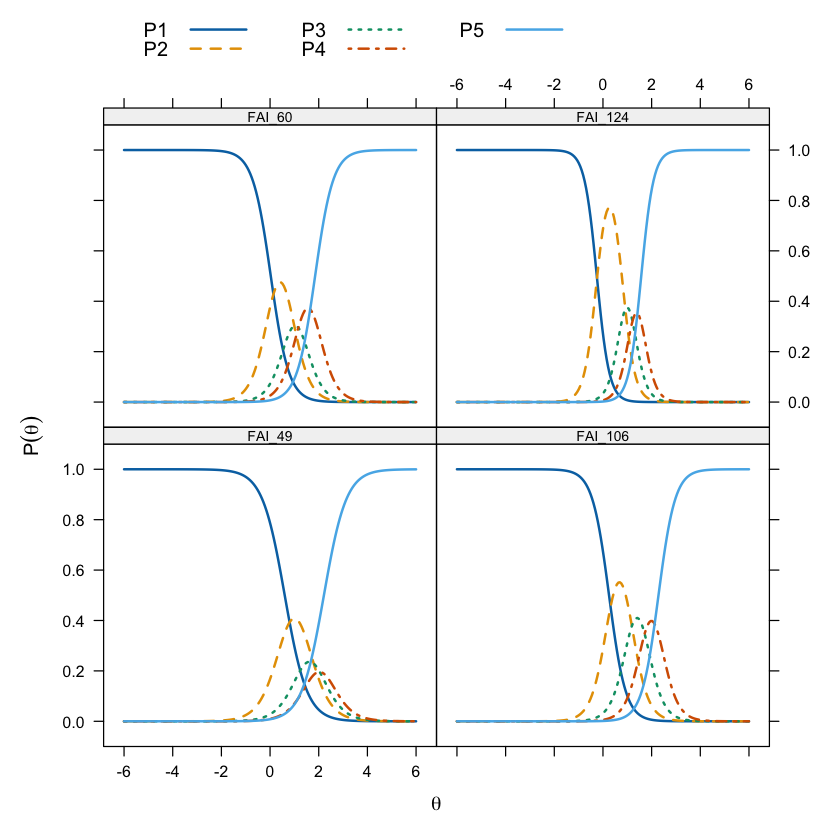

In [40]:
n_item <- length(names(good_items))
plot(
    mod,
    type = "trace",
    which.items = 1:n_item,
    main = "",
    par.settings = simpleTheme(lty = 1:4, lwd = 2),
    auto.key = list(points = FALSE, lines = TRUE, columns = 4)
)

- Grafici di Tracciamento: ogni curva rappresenta la probabilità di scegliere una specifica categoria di risposta in funzione del tratto latente. Le curve più ripide indicano una maggiore discriminazione dell'item: l'item è più sensibile nel distinguere tra soggetti con livelli leggermente diversi del tratto.

Questi grafici mostrano la quantità di informazione fornita da ciascun item a diversi livelli del tratto latente.

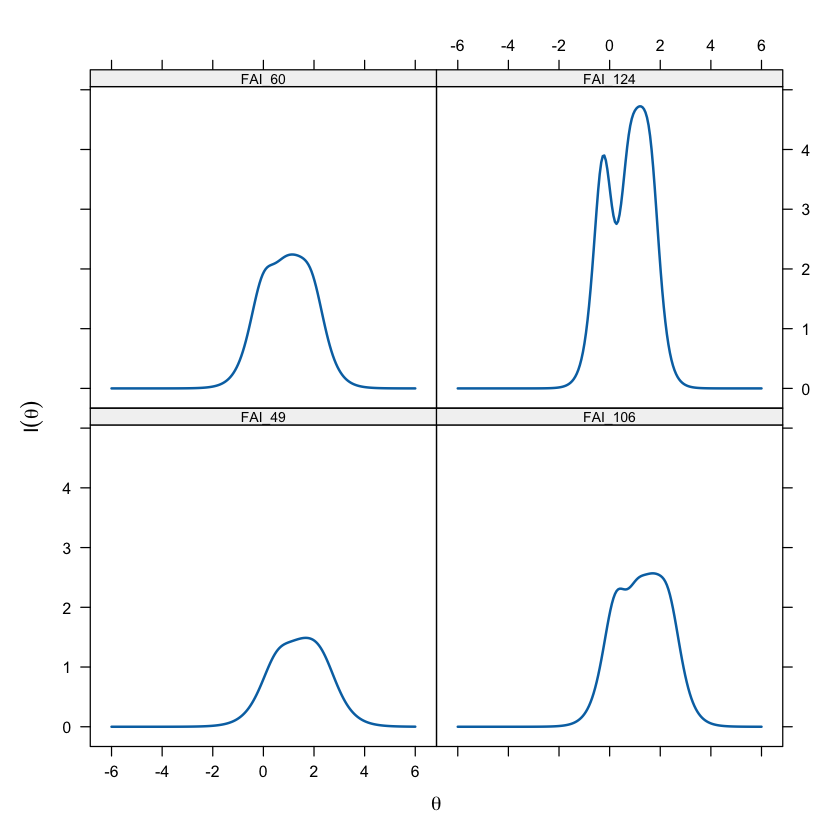

In [41]:
plot(
    mod,
    type = "infotrace",
    which.items = 1:n_item,
    main = "",
    par.settings = simpleTheme(lwd = 2)
)

- Grafici delle Funzioni di Informazione degli Item (IIF). L'altezza della curva in un dato punto indica la quantità di informazione che l'item fornisce a quel livello specifico del tratto latente. Picchi più alti indicano che un item fornisce più informazione per soggetti con quel particolare livello del tratto. La larghezza del picco indica la gamma di livelli del tratto per cui l'item è informativo. Un picco più ampio suggerisce che l'item è utile per un'ampia gamma di livelli del tratto.

In conclusione, gli item che mostrano picchi più alti e più ampi nelle loro funzioni di informazione sono particolarmente utili per la misurazione del tratto, poiché forniscono una grande quantità di informazione su un'ampia gamma di livelli del tratto.

Nel caso presente, i grafici delle Funzioni di Informazione degli Item mostrano che gli item sono adatti soprattutto per misurare rispondenti con un livello intermedio di abilità latente.

## Analisi fattoriale

In [44]:
KMO(good_items)

Kaiser-Meyer-Olkin factor adequacy
Call: KMO(r = good_items)
Overall MSA =  0.81
MSA for each item = 
 FAI_49 FAI_106  FAI_60 FAI_124 
   0.86    0.81    0.81    0.77 

L'indice di Kaiser-Meyer-Olkin (KMO) è una misura di idoneità dei dati per l'analisi fattoriale. Esso varia da 0 a 1, con valori più alti che indicano una maggiore idoneità dei dati per l'analisi fattoriale. Un valore KMO elevato suggerisce che le correlazioni parziali tra gli item sono basse e quindi gli item hanno abbastanza in comune per giustificare un'analisi fattoriale. 

Nel caso presente, abbiamo ottenuto `Overall MSA = 0.81`.  Questo è un valore molto buono, indicando che nel complesso, il tuo set di dati è ben adatto per l'analisi fattoriale. 

Il test di sfericità di Bartlett è un test statistico usato per verificare l'ipotesi che una matrice di correlazione sia una matrice di identità, il che implicherebbe che le variabili sono indipendenti e non correlate tra loro. Il test di Bartlett è utilizzato nell'ambito dell'analisi fattoriale per valutare se i dati sono adatti per tale analisi. 

In [48]:
cortest.bartlett(R = cor(good_items), n = nrow(good_items))

$chisq
[1] 765.8992

$p.value
[1] 3.58605e-162

$df
[1] 6

Il p-value estremamente basso indica che è altamente improbabile ottenere una statistica chi-quadro così elevata se l'ipotesi nulla fosse vera. In altre parole, è molto probabile che le variabili (item) siano correlate tra loro. Il risultato del test di Bartlett supporta l'idoneità dei dati per l'analisi fattoriale. 

La parallel analysis suggerisce una soluzione ad un fattore.

Parallel analysis suggests that the number of factors =  1  and the number of components =  1 


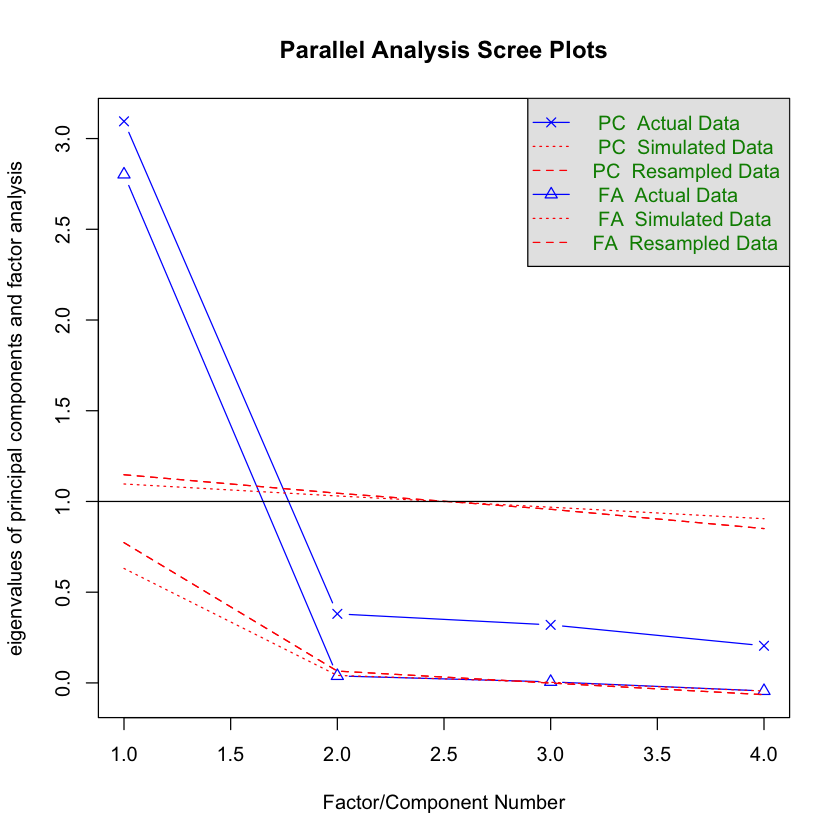

In [49]:
fa.parallel(good_items, cor = "poly")

Eseguiamo l'analisi fattoriale confermativa.

In [50]:
one_factor_model <- "
  F =~ FAI_124 + FAI_106 + FAI_60 + FAI_49
"

fit <- lavaan:::cfa(
    one_factor_model,
    data = good_items,
    ordered = names(good_items),
    std.lv = TRUE
)

# summary(fit, standardized = TRUE)
fitMeasures(
    fit, 
    c(
        "chisq", "df", "cfi", "cfi.scaled", "tli", "tli.scaled",
        "rmsea", "rmsea.scaled", "srmr"
    )
)

chisq           df          cfi   cfi.scaled          tli   tli.scaled 
       1.552        2.000        1.000        0.999        1.000        0.997 
       rmsea rmsea.scaled         srmr 
       0.000        0.054        0.014

Le misure di bontà di adattamento sono eccellenti.